Microsoft AI Rangers Demo

# Cell Segmentation with Automated Machine Learning for Images

__In this notebook__

- Convert LIVECell annotations to AutoML for Images format
- Upload annotations to Azure Machine Learning
- Perform baseline segmentation training run
- Perform automated hyperparameter search to find the best model
- Evaluate segmentations based on test set

# Cell Segmentation Use Case
Light microscopy is a cheap, accessible, non-invasive modality that when combined with well-established protocols of two-dimensional cell culture facilitates high-throughput quantitative imaging to study biological phenomena. Accurate segmentation of individual cells enables exploration of complex biological questions, but this requires sophisticated imaging processing pipelines due to the low contrast and high object density. Deep learning-based methods are considered state-of-the-art for most computer vision problems but require vast amounts of annotated data, for which there is no suitable resource available in the field of label-free cellular imaging. LIVECell is a high-quality, manually annotated and expert-validated dataset that is the largest of its kind to date, consisting of over 1.6 million cells from a diverse set of cell morphologies and culture densities.
<img src="./images/cell-types.png" width=600 />

Edlund, C., Jackson, T.R., Khalid, N. et al. LIVECell—A large-scale dataset for label-free live cell segmentation. Nat Methods 18, 1038–1045 (2021). https://doi.org/10.1038/s41592-021-01249-6

# Installs and imports
We are using an Azure ML Compute Instance for executing this notebook.

Depending on the Azure ML SDK version that you are using, it might be necessary to update to the azureml-train-automl-client 1.35 to avoid the following error: ``ImportError: cannot import name AutoMLConfig``.

In [4]:
# %pip install azureml-train-automl-client==1.35.0
# %pip install jsonlines
# %pip install --upgrade matplotlib

In [16]:
import json
import jsonlines
from azureml.core.workspace import Workspace

ws = Workspace.from_config()
ds = ws.get_default_datastore()

# Upload LIVECell dataset to Default Workspace Datastore
Download the LIVECell images dataset that can be found here: https://sartorius-research.github.io/LIVECell/. 

Using the Azure Storage Explorer, upload it to a folder called livecell/livecell_train_val_images in the Default Workspace Datastore.

# Convert and upload LIVECell annotations for using Automated ML for Images
The following cell illustrates the required JSONL based target format for Automated ML for images as described here: https://docs.microsoft.com/en-us/azure/machine-learning/reference-automl-images-schema.

## Automated ML annotation structure
We need to convert the annotations of the LIVECell dataset below, in order to use it with AutoML.

In [17]:
{
   "image_url":"AmlDatastore://data_directory/../Image_name.image_format",
   "image_details":{
      "format":"image_format",
      "width":"image_width",
      "height":"image_height"
   },
   "label":[
      {
         "label":"class_name",
         "isCrowd":"isCrowd",
         "polygon":[["x1", "y1", "x2", "y2", "x3", "y3", "...", "xn", "yn"]]
      }
   ]
}

{'image_url': 'AmlDatastore://data_directory/../Image_name.image_format',
 'image_details': {'format': 'image_format',
  'width': 'image_width',
  'height': 'image_height'},
 'label': [{'label': 'class_name',
   'isCrowd': 'isCrowd',
   'polygon': [['x1', 'y1', 'x2', 'y2', 'x3', 'y3', '...', 'xn', 'yn']]}]}

## Load dataset and calculate max annotations per image

There are several data set splits available for working with the LIVECell images. See https://sartorius-research.github.io/LIVECell for more details. In order to reduce training time for our demo, we are using 50% of the available data set size. *Make sure to download the annotation file of choice to a local folder called datasets.*

The images of the LIVECell data set include a high number of segmentation polygons. The number of predictions is a hyperparameter of Automated ML for Images that defaults to 100. In order to adjust the parameter for this data set, we are extracting the maximum number of polygons in the sample. 

In [19]:
# read original LIVEcell annotation file 
livecell_annotations = './datasets/4_train50percent.json'
with open(livecell_annotations) as json_file:
    source = json.load(json_file)


# check max. number of annotations per image for box_detections_per_img hyperparameter 
annotations_per_image = []

for img_idx, image in enumerate(source['images']):
    id = image['id']
    image_annotations = [annotation for annotation in source['annotations'] if annotation['image_id'] == id]
    annotations_per_image.append(len(image_annotations))

print ('Maximum number of annotations per image:', max(annotations_per_image))

Maximum number of annotations per image: 3091


## Generate Automated ML annotations

Now we convert the annotations from the original COCO format into the JSONL based format that Automated ML for Images is using. Note that this step has to only performed once per data set sample. If the JSONL based annotation file already exists for the data set split you want to use, the following cell can be skipped. 

In [20]:
from utils.utils import generate_jsonl_annotations

annotations = []
target_path = 'AmlDatastore://workspaceblobstore/livecell/livecell_train_val_images'
annotation_file = './annotations/annotation-train50percent.jsonl'

generate_jsonl_annotations(source, target_path, annotation_file)

In [11]:
# uncomment for uploading annotation files to the AML datastore
# ds.upload(src_dir='./annotations', target_path='livecell/livecell_train_val_images', overwrite=True)

# Load training images

## Retrieve Training Data Set
If the dataset does not exist yet, we are generating a Labeled Dataset based on the images and annotations that are uploaded to the Default Workspace Datastore.

We also load the dataset as a Pandas dataframe, so we can use it for visualizations.

In [21]:
from azureml.contrib.dataset.labeled_dataset import _LabeledDatasetFactory, LabeledDatasetTask
from azureml.core import Dataset
from azureml.contrib.dataset import FileHandlingOption

training_dataset_name = 'livecellTrainingDataset50percent'
if training_dataset_name in ws.datasets:
    training_dataset = ws.datasets.get(training_dataset_name)
    print('Found the training dataset', training_dataset_name)
else:
    # create training dataset
    training_dataset = _LabeledDatasetFactory.from_json_lines(
        task=LabeledDatasetTask.IMAGE_INSTANCE_SEGMENTATION, path=ds.path('livecell/livecell_train_val_images/annotation-train50percent.jsonl'))
    training_dataset = training_dataset.register(workspace=ws, name=training_dataset_name)

    
training_data_pd = training_dataset.to_pandas_dataframe(file_handling_option=FileHandlingOption.MOUNT)

print("Training dataset name: " + training_dataset.name)

Found the training dataset livecellTrainingDataset50percent
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.PipelineRun = azureml.pipeline.core.run:PipelineRun._from_dto with exception (azureml-core 1.35.0.post1 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('azureml-core~=1.34.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.ReusedStepRun = azureml.pipeline.core.run:StepRun._from_reused_dto with exception (azureml-core 1.35.0.post1 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('azureml-core~=1.34.0')).
Failure while loading azureml_run_type_providers. Failed to load entrypoint azureml.StepRun = azureml.pipeline.core.run:StepRun._from_dto with exception (azureml-core 1.35.0.post1 (/anaconda/envs/azureml_py36/lib/python3.6/site-packages), Requirement.parse('azureml-core~=1.34.0')).
Training dataset name: livecellTrainingDataset50percent


## Create set of test images

In [22]:
def get_img_url_from_class(class_name):
    return training_data_pd[training_data_pd['image_url'].str.contains(class_name)]['image_url'].iloc[0]

classes = ["SKOV3", "A172", "BT474", "BV2", "Huh7", "MCF7", "SHSY5Y", "SkBr3"]

test_images = []
for class_name in classes:
    test_images.append(get_img_url_from_class(class_name))

print(test_images)


['/tmp/tmpcc2dj2_5/workspaceblobstore/livecell/livecell_train_val_images/SKOV3/SKOV3_Phase_G4_1_00d20h00m_3.tif', '/tmp/tmpcc2dj2_5/workspaceblobstore/livecell/livecell_train_val_images/A172/A172_Phase_B7_2_00d08h00m_3.tif', '/tmp/tmpcc2dj2_5/workspaceblobstore/livecell/livecell_train_val_images/BT474/BT474_Phase_A3_1_02d16h00m_2.tif', '/tmp/tmpcc2dj2_5/workspaceblobstore/livecell/livecell_train_val_images/BV2/BV2_Phase_B4_2_00d12h00m_1.tif', '/tmp/tmpcc2dj2_5/workspaceblobstore/livecell/livecell_train_val_images/Huh7/Huh7_Phase_A10_2_03d04h00m_1.tif', '/tmp/tmpcc2dj2_5/workspaceblobstore/livecell/livecell_train_val_images/MCF7/MCF7_Phase_G4_2_01d12h00m_2.tif', '/tmp/tmpcc2dj2_5/workspaceblobstore/livecell/livecell_train_val_images/SHSY5Y/SHSY5Y_Phase_B10_1_01d08h00m_4.tif', '/tmp/tmpcc2dj2_5/workspaceblobstore/livecell/livecell_train_val_images/SkBr3/SkBr3_Phase_E3_2_00d20h00m_1.tif']


## Review original images and segmentation polygons

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from utils.utils import plot_ground_truth_boxes_jsonl

jsonl_file = "annotations/annotation-train50percent.jsonl"

for image in test_images:
    plot_ground_truth_boxes_jsonl(image, jsonl_file)


# Perform baseline run with fixed basic hyperparameters
Automated ML for Images helps you finding the best combination of algorithms and hyperparameters for your computer vision task. The search space of algorithms and hyperparameters is specified in the ``parameter space`` dictionary.
In this demo, we will perform a baseline experiment with fixed hyperparameters before we move to a more comprehensive search in the subsequent cells.

In [6]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, choice

parameter_space = {
    'model_name': choice('maskrcnn_resnet101_fpn'),
    'max_size': choice(600), # images are of size 704 x 520. Got CUDA OOM error with higher resolutuons
    'box_detections_per_img' : choice(3100) # Adjusted for maximum number of segmentation polygons in training set. AutoML for images default = 100
}

image_config_maskrcnn = AutoMLImageConfig(
      task = ImageTask.IMAGE_INSTANCE_SEGMENTATION,
      compute_target = ws.compute_targets["gpu-clu-nv24v3"],
      training_data = training_dataset,
      hyperparameter_sampling = GridParameterSampling(parameter_space),
      iterations=1)

In [3]:
from azureml.core import Experiment

experiment_name = 'livecell-image-segmentation' 
experiment = Experiment(ws, name=experiment_name)

In [8]:
automl_image_run = experiment.submit(image_config_maskrcnn)

Submitting remote run.


## Retrieve experiment data

In [5]:
from azureml.core import Run, Experiment

automl_image_run = Run(experiment=Experiment(ws,'livecell-image-segmentation'), run_id='AutoML_4aba9b17-a7f1-4f96-9740-e94808edf47b_HD_3')
automl_image_run

Run(Experiment: livecell-image-segmentation,
Id: AutoML_4aba9b17-a7f1-4f96-9740-e94808edf47b_HD_3,
Type: azureml.scriptrun,
Status: Completed)

# Register best model

In [6]:
model = automl_image_run.register_model('livecell-automl', 'outputs/model.pt')

# Deploy model

## Create / get compute cluster

In [7]:
from azureml.core.compute import ComputeTarget, AksCompute
from azureml.exceptions import ComputeTargetException

# Choose a name for your cluster
aks_name = "aks-cpu-is"
# Check to see if the cluster already exists
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing compute target")
except ComputeTargetException:
    print("Creating a new compute target...")
    # Provision AKS cluster with a CPU machine
    prov_config = AksCompute.provisioning_configuration(vm_size="STANDARD_D3_V2")
    # Create the cluster
    aks_target = ComputeTarget.create(
        workspace=ws, name=aks_name, provisioning_configuration=prov_config
    )
    aks_target.wait_for_completion(show_output=True)


Found existing compute target


## Download scoring script and define inference config

In [8]:
from azureml.core.model import InferenceConfig

environment = automl_image_run.get_environment()
inference_config = InferenceConfig(entry_script="scripts/score.py", environment=environment)

## Deploy model

In [13]:
# Deploy the model from the best run as an AKS web service
from azureml.core.webservice import AksWebservice
from azureml.core.model import Model

aks_config = AksWebservice.deploy_configuration(
    autoscale_enabled=True, cpu_cores=1, memory_gb=5, enable_app_insights=True
)

aks_service = Model.deploy(
    ws,
    models=[model],
    inference_config=inference_config,
    deployment_config=aks_config,
    deployment_target=aks_target,
    name="automl-image-test-cpu-is",
    overwrite=True,
)
aks_service.wait_for_deployment(show_output=True)
print(aks_service.state)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running
2021-11-17 08:33:44+00:00 Creating Container Registry if not exists.
2021-11-17 08:33:45+00:00 Registering the environment.
2021-11-17 08:33:45+00:00 Use the existing image.
2021-11-17 08:33:47+00:00 Checking the status of deployment automl-image-test-cpu-is..
2021-11-17 08:34:07+00:00 Checking the status of inference endpoint automl-image-test-cpu-is.
Succeeded
AKS service creation operation finished, operation "Succeeded"
Healthy


# Predict segmentations and visualize results

Downloaded path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/livecell/livecell_train_val_images/SKOV3/SKOV3_Phase_G4_1_00d20h00m_3.tif is different from target path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/workspaceblobstore/livecell/livecell_train_val_images/SKOV3/SKOV3_Phase_G4_1_00d20h00m_3.tif


<Figure size 432x288 with 0 Axes>

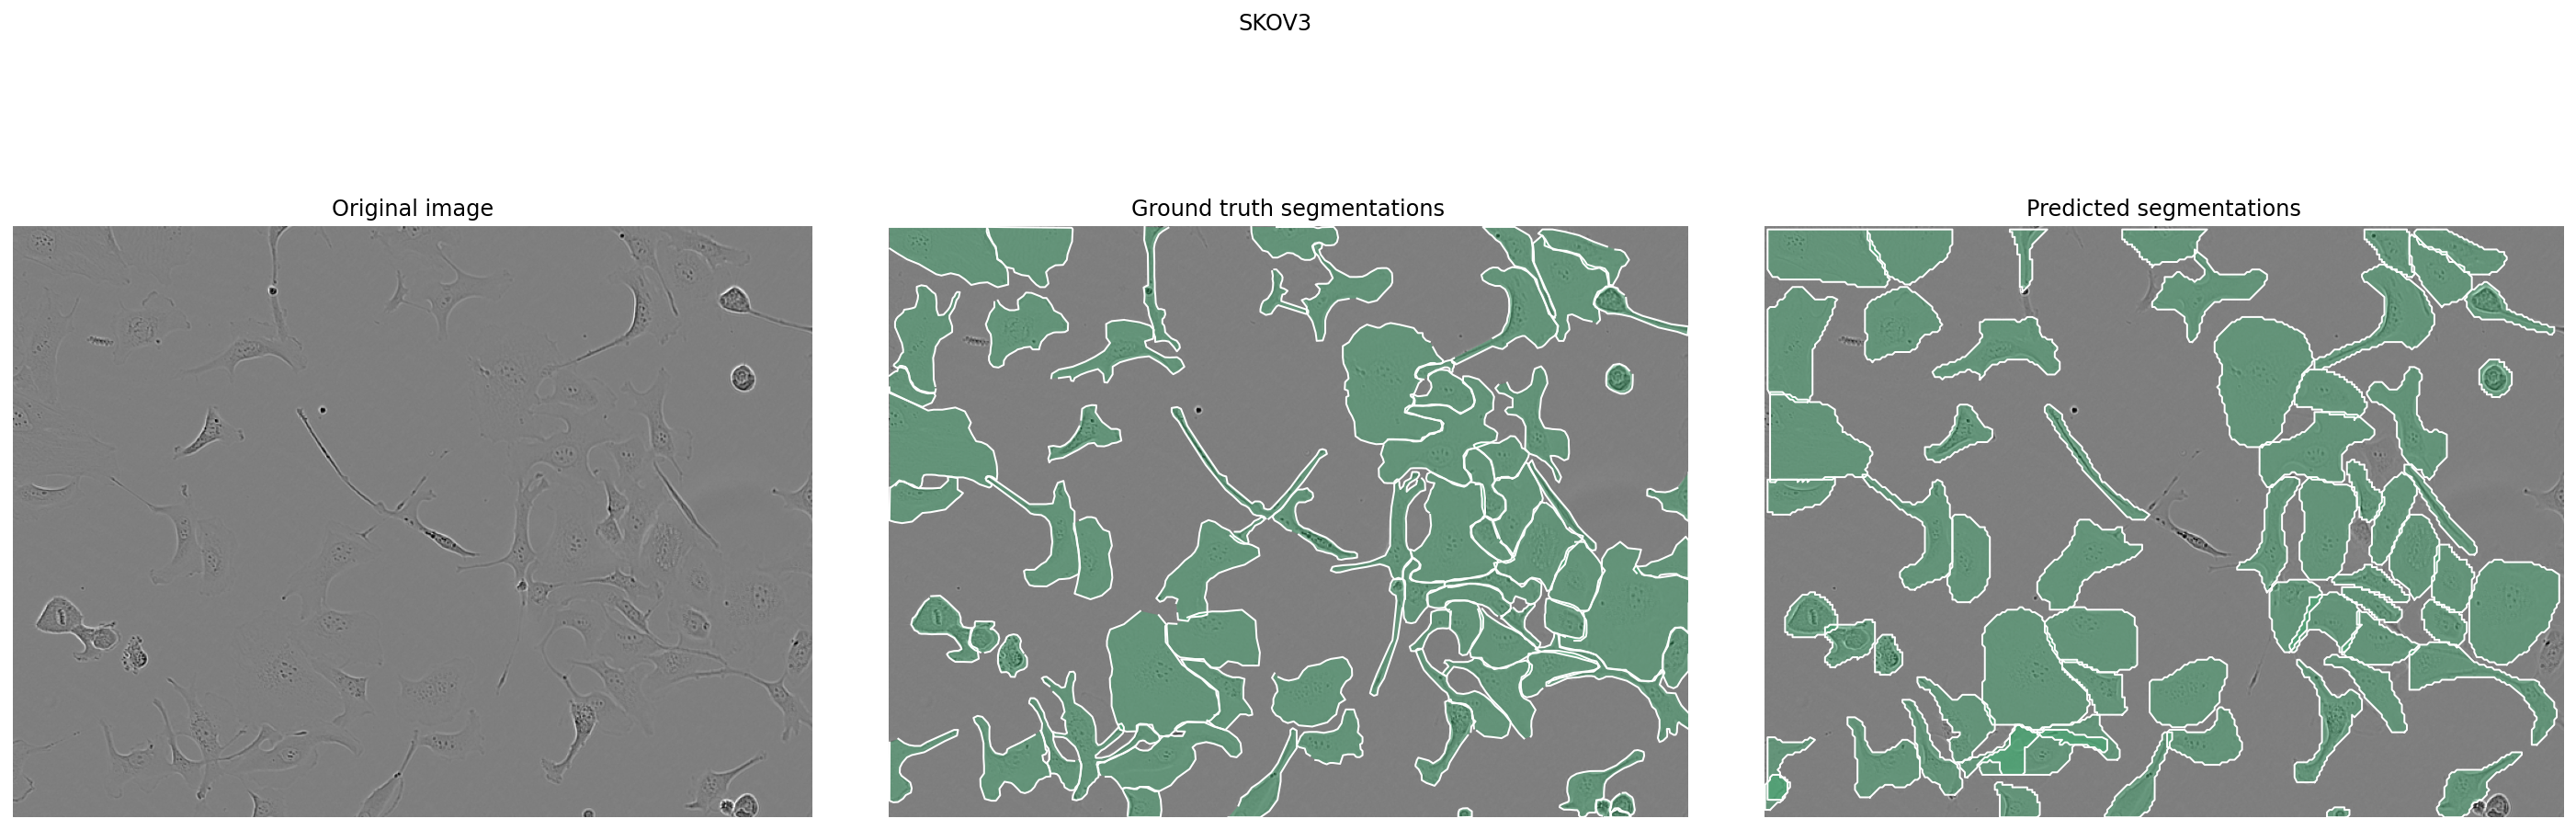

Downloaded path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/livecell/livecell_train_val_images/A172/A172_Phase_B7_2_00d08h00m_3.tif is different from target path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/workspaceblobstore/livecell/livecell_train_val_images/A172/A172_Phase_B7_2_00d08h00m_3.tif


<Figure size 432x288 with 0 Axes>

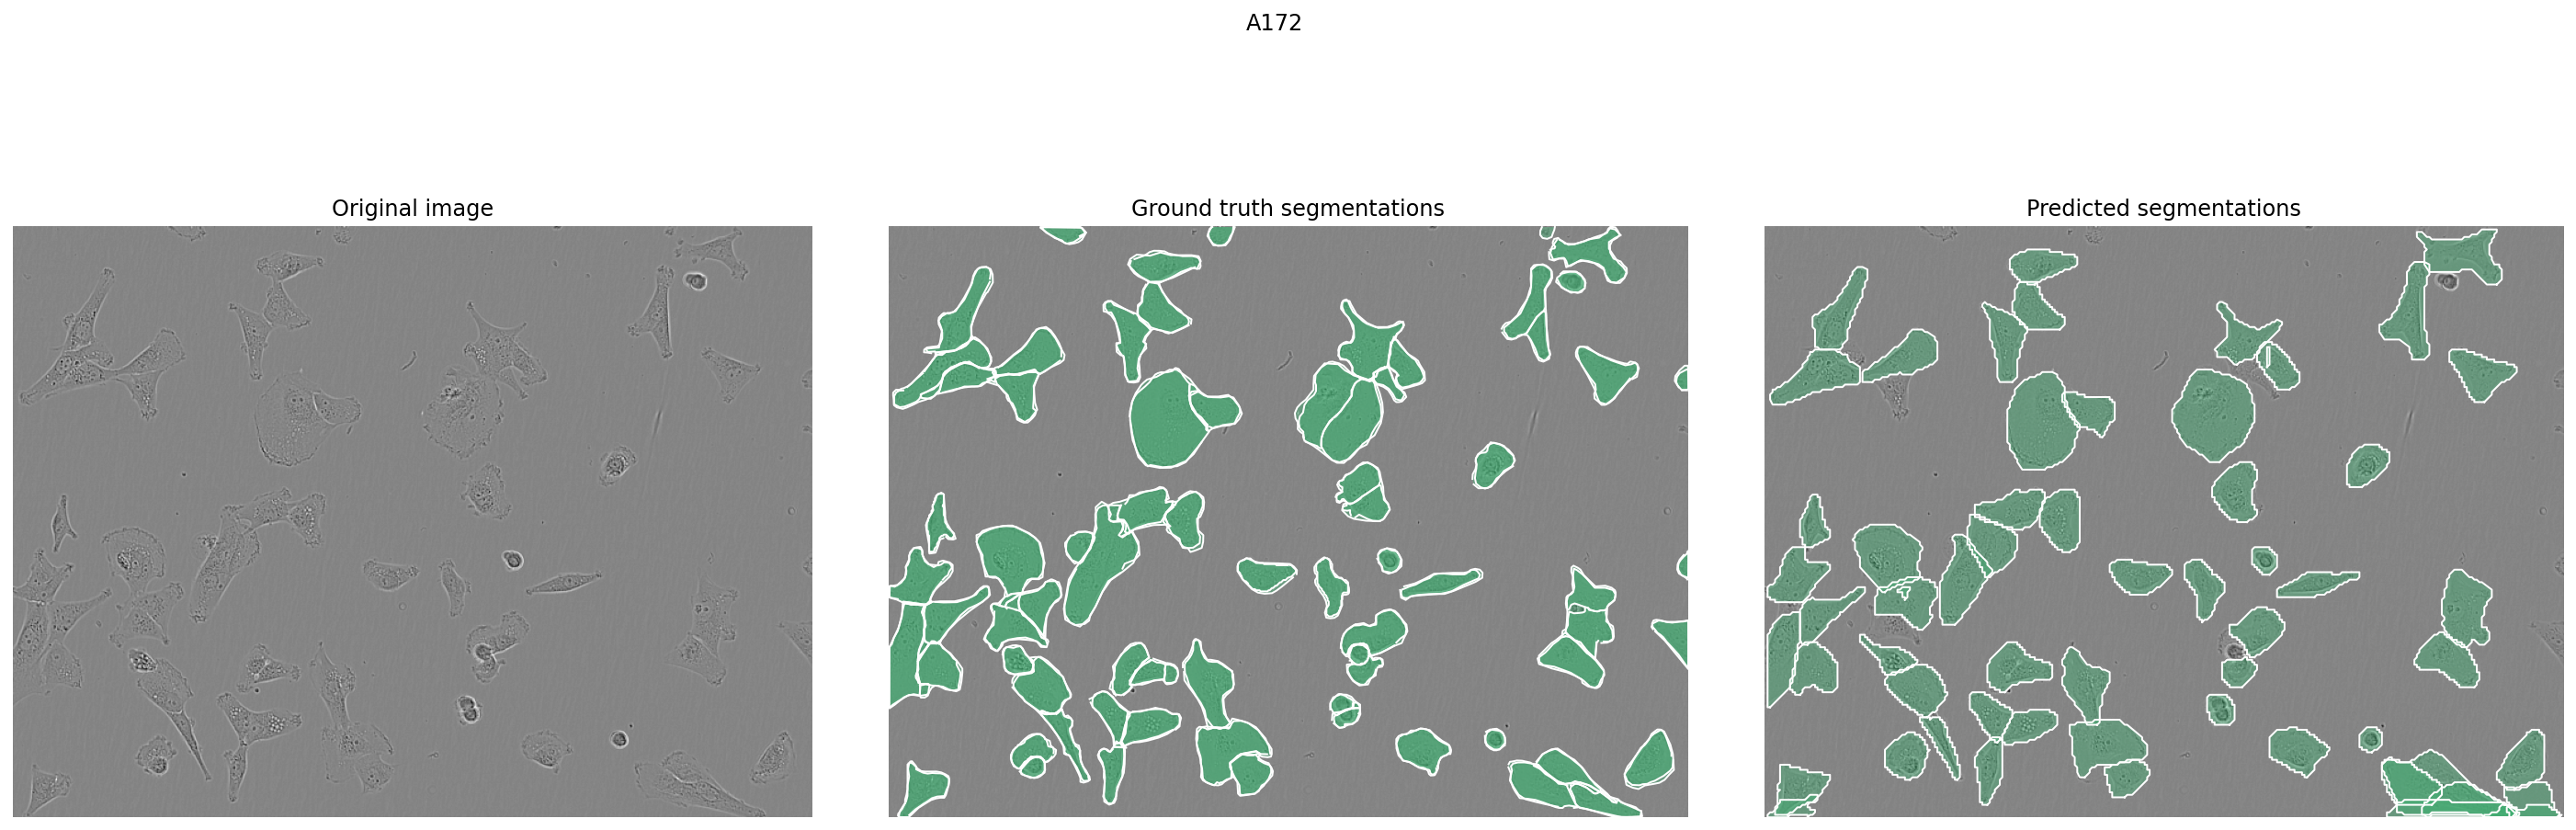

Downloaded path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/livecell/livecell_train_val_images/BT474/BT474_Phase_A3_1_02d16h00m_2.tif is different from target path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/workspaceblobstore/livecell/livecell_train_val_images/BT474/BT474_Phase_A3_1_02d16h00m_2.tif


<Figure size 432x288 with 0 Axes>

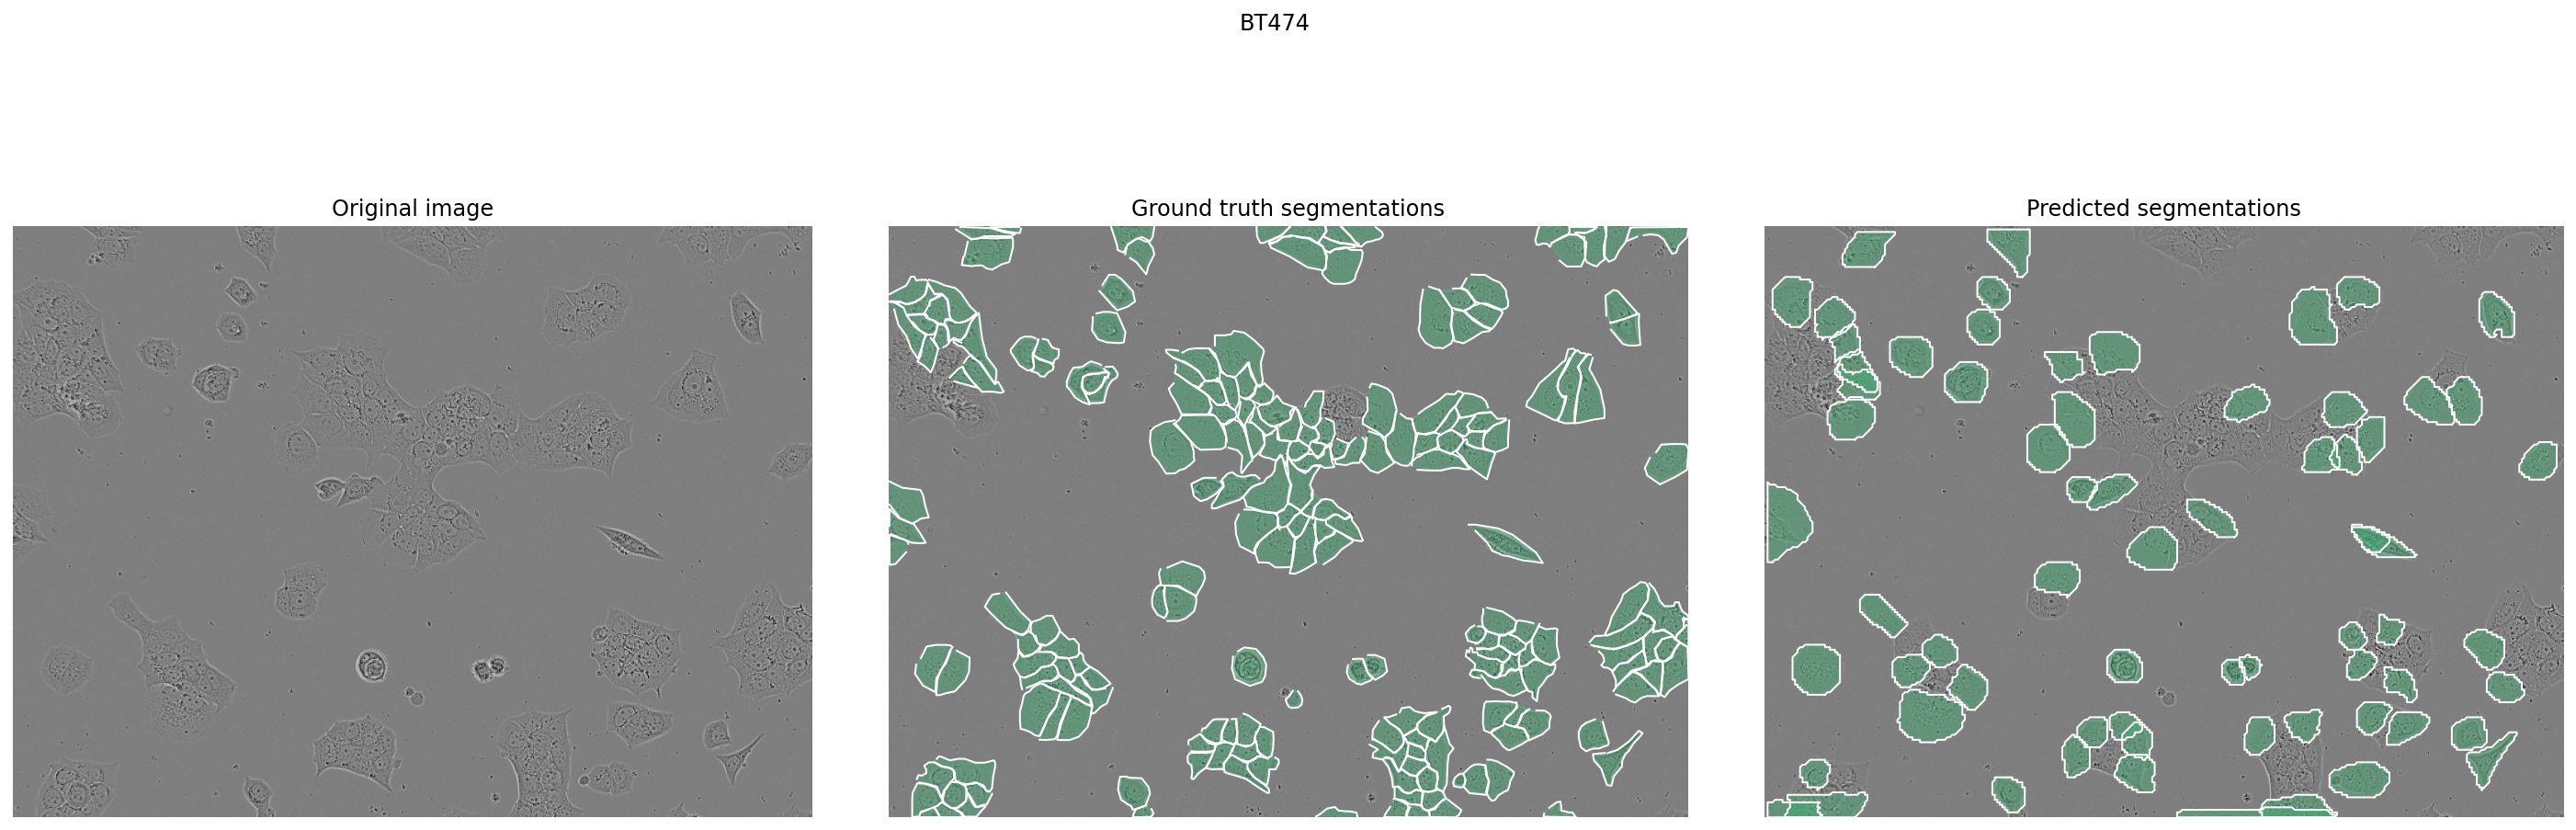

Downloaded path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/livecell/livecell_train_val_images/BV2/BV2_Phase_B4_2_00d12h00m_1.tif is different from target path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/workspaceblobstore/livecell/livecell_train_val_images/BV2/BV2_Phase_B4_2_00d12h00m_1.tif


<Figure size 432x288 with 0 Axes>

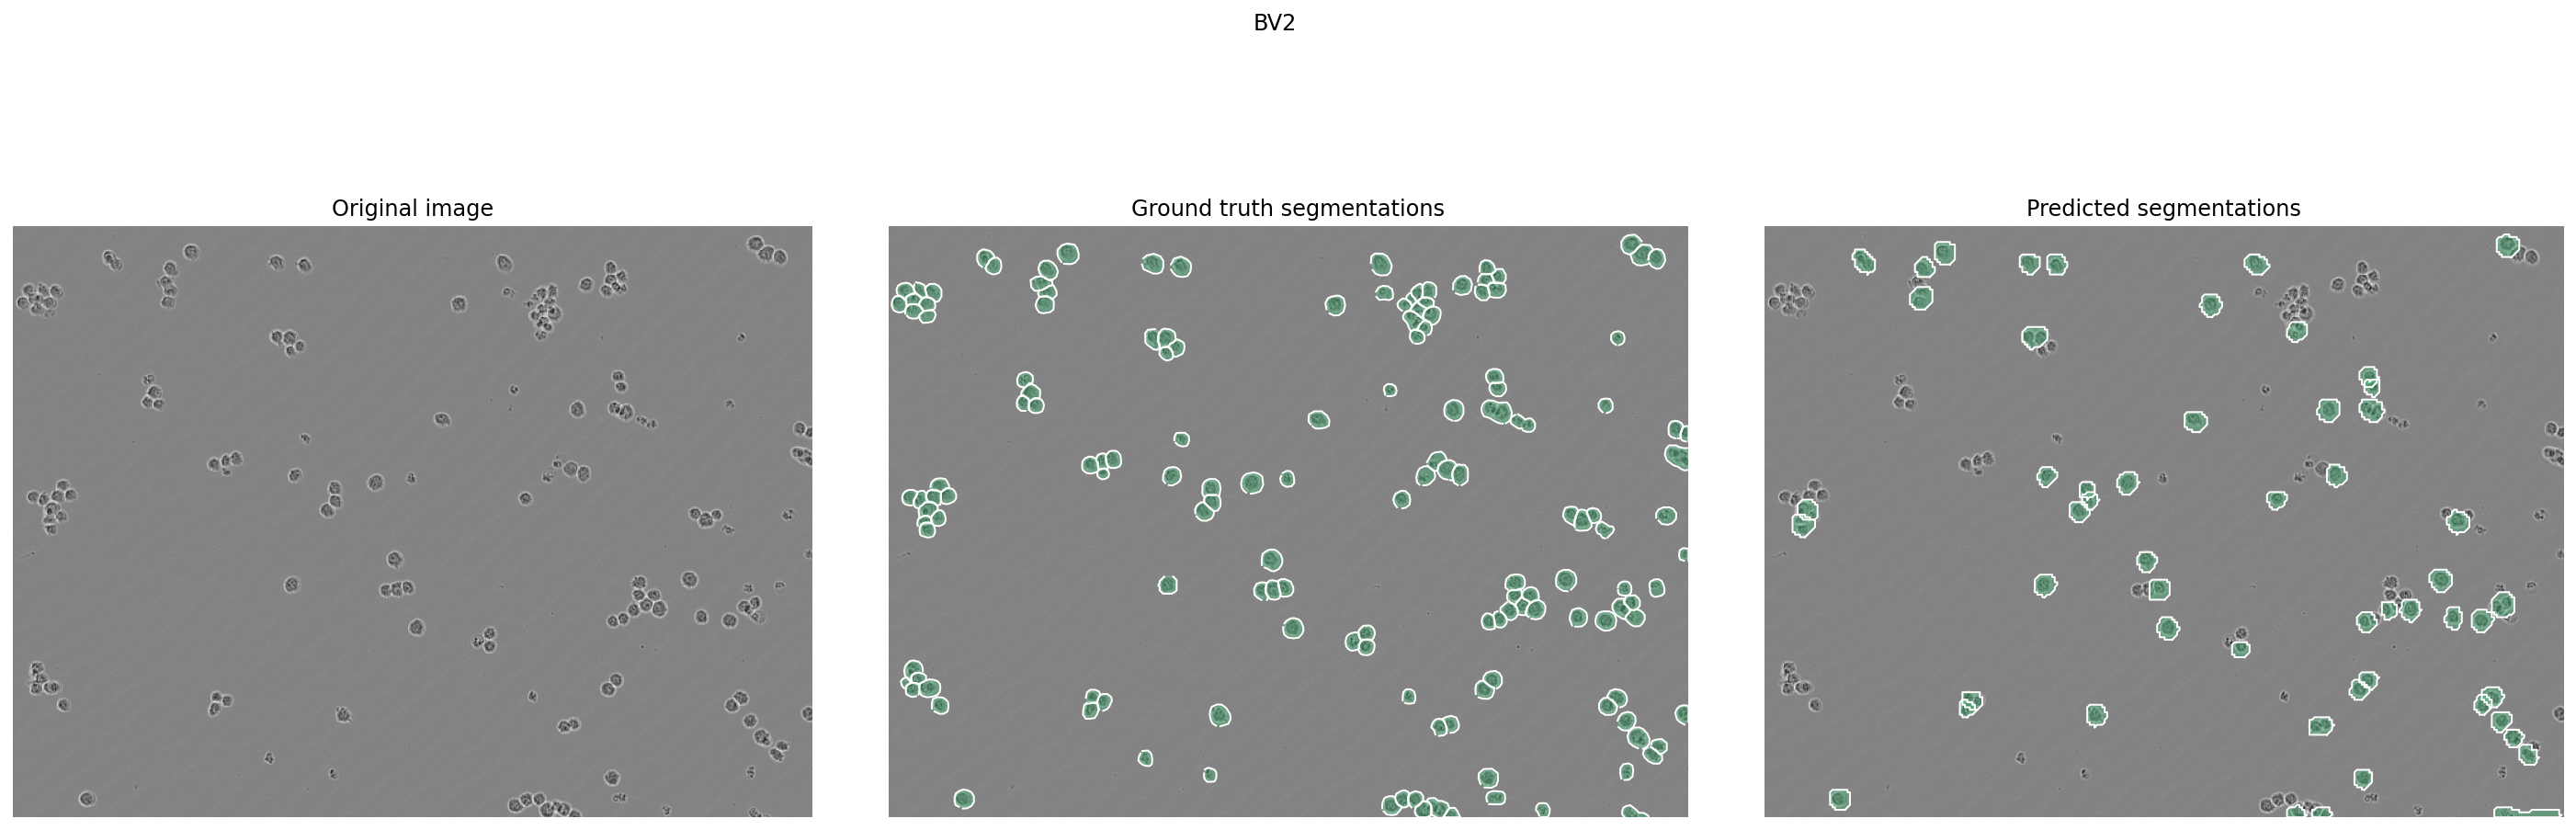

Downloaded path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/livecell/livecell_train_val_images/Huh7/Huh7_Phase_A10_2_03d04h00m_1.tif is different from target path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/workspaceblobstore/livecell/livecell_train_val_images/Huh7/Huh7_Phase_A10_2_03d04h00m_1.tif


<Figure size 432x288 with 0 Axes>

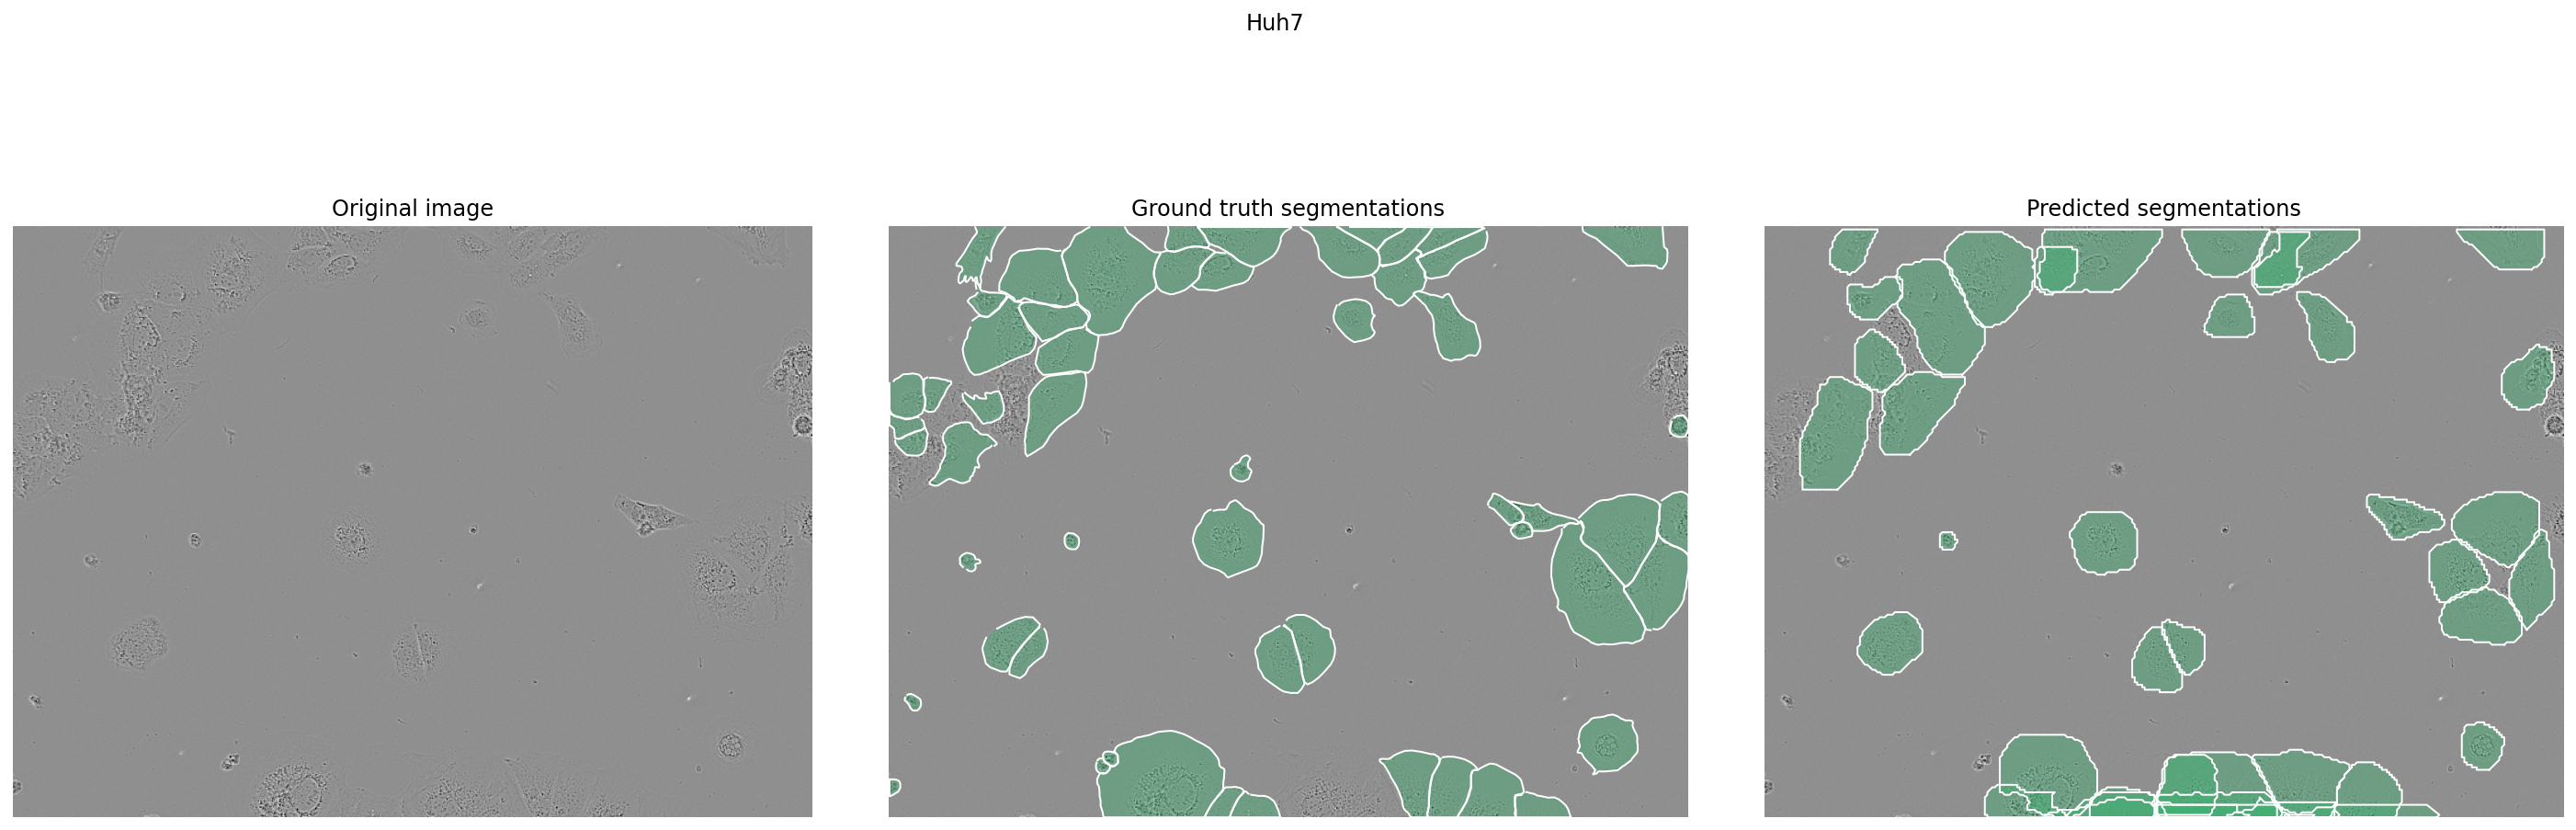

Downloaded path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/livecell/livecell_train_val_images/MCF7/MCF7_Phase_G4_2_01d12h00m_2.tif is different from target path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/workspaceblobstore/livecell/livecell_train_val_images/MCF7/MCF7_Phase_G4_2_01d12h00m_2.tif


<Figure size 432x288 with 0 Axes>

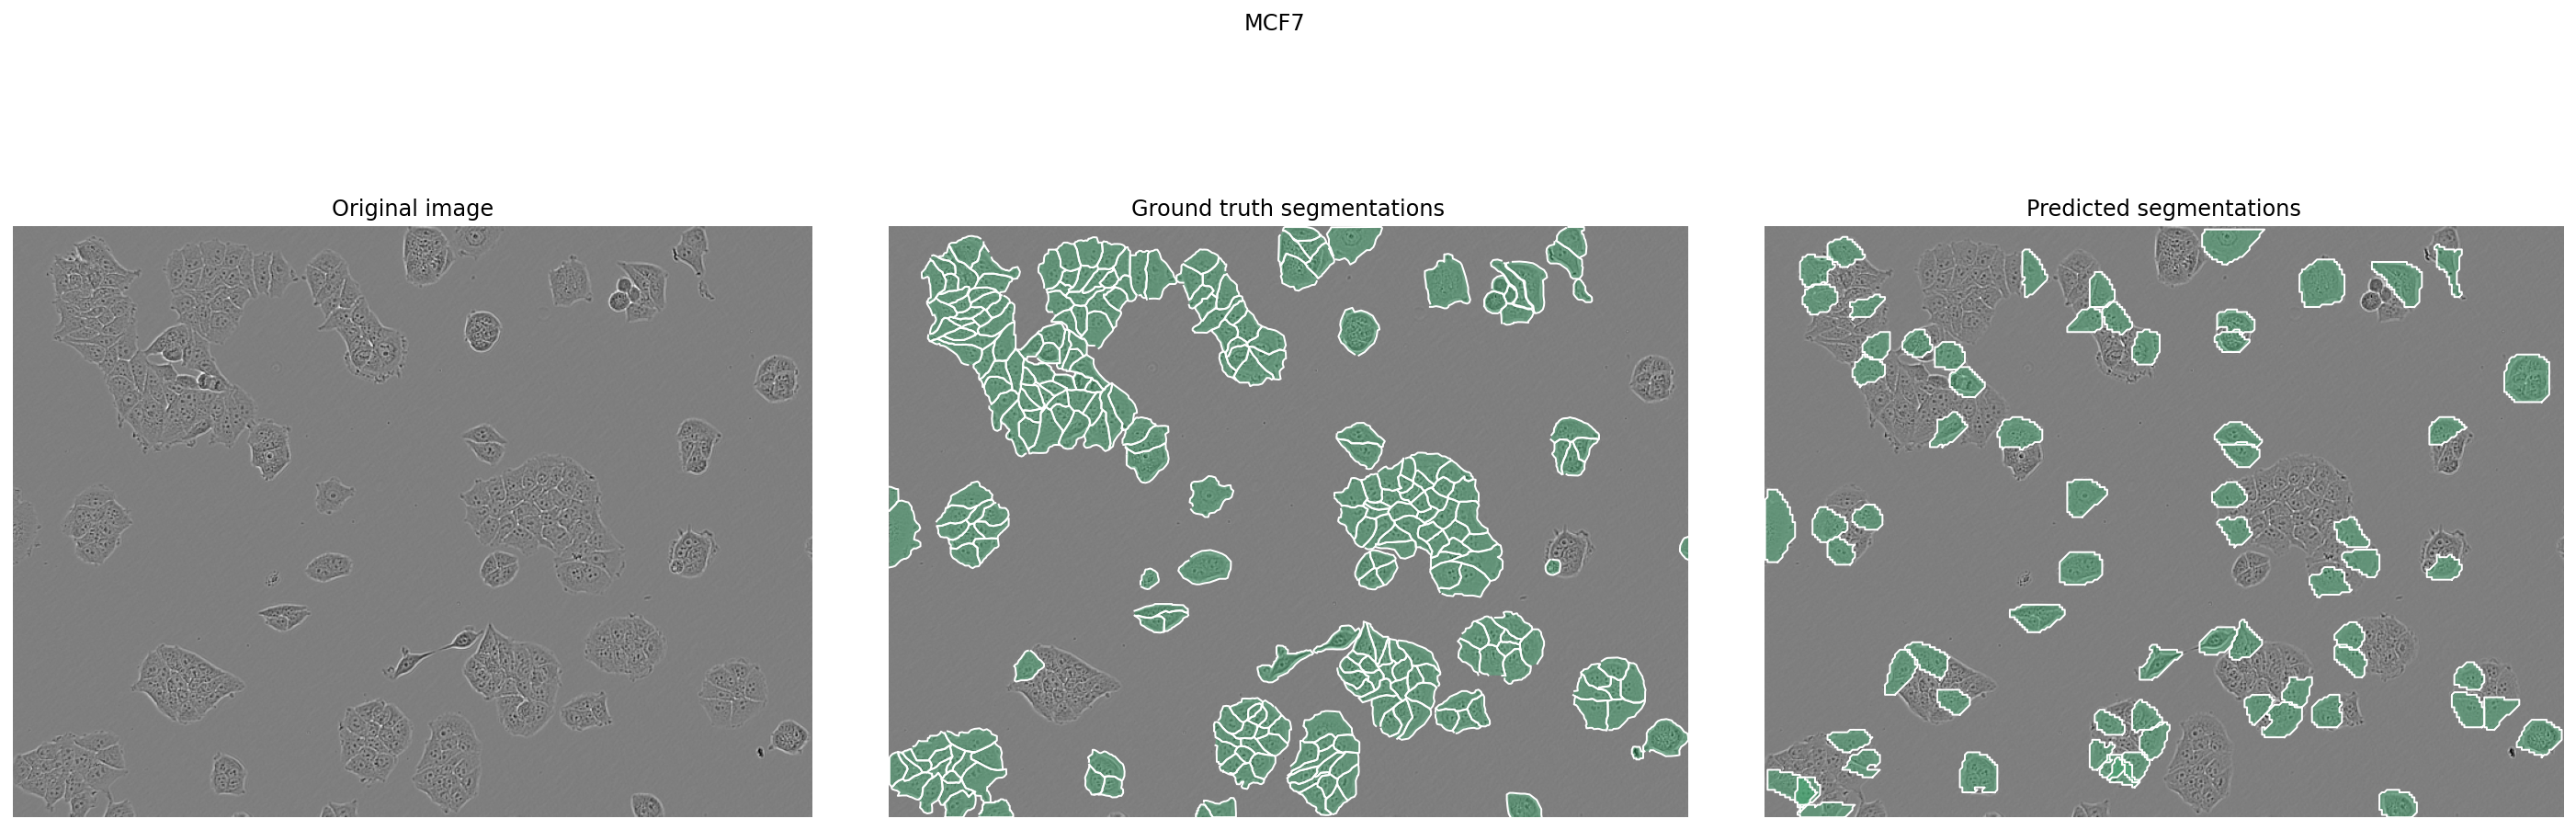

Downloaded path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/livecell/livecell_train_val_images/SHSY5Y/SHSY5Y_Phase_B10_1_01d08h00m_4.tif is different from target path: /tmp/tmp_f7gvr9y/bac6697f-cf08-4fd7-85c0-048dfd3a190a/workspaceblobstore/livecell/livecell_train_val_images/SHSY5Y/SHSY5Y_Phase_B10_1_01d08h00m_4.tif


<Figure size 432x288 with 0 Axes>

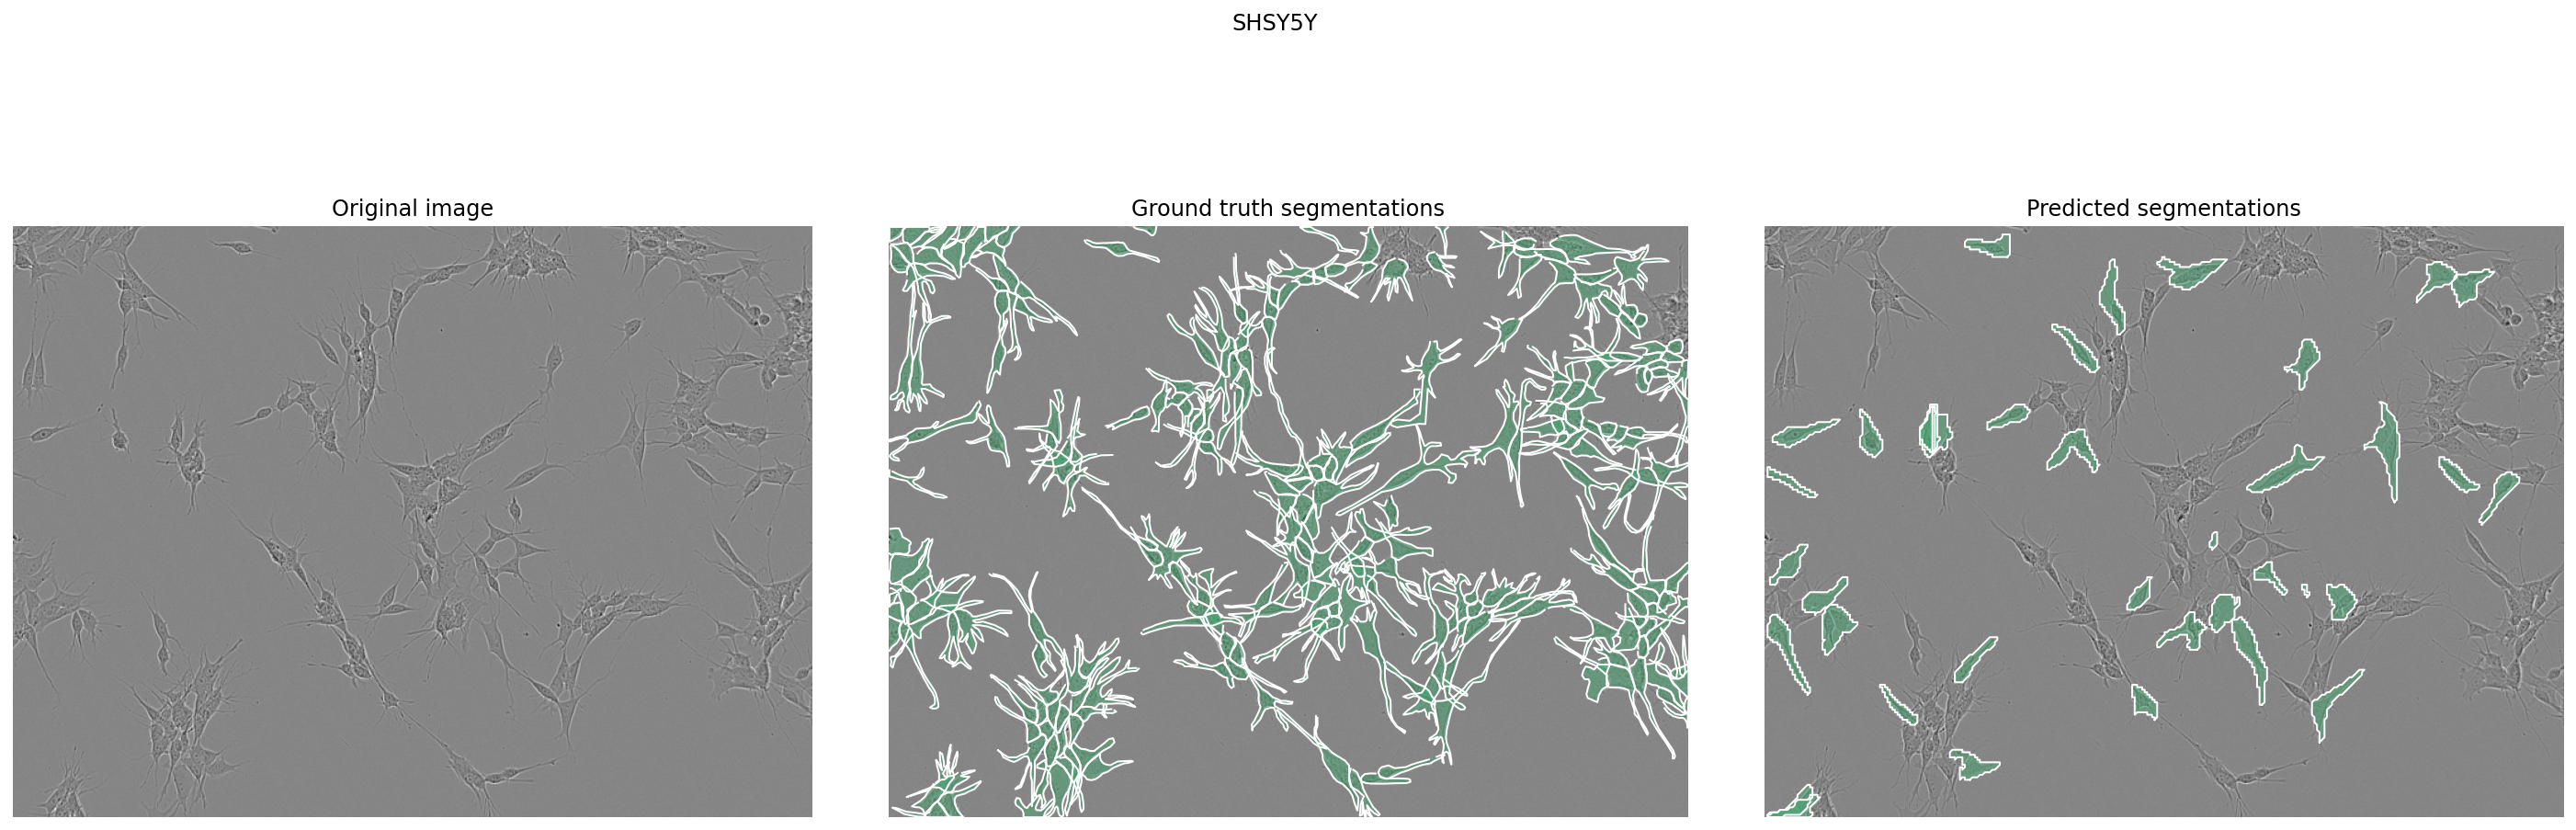

In [23]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from utils.utils import plot_predicted_segmentations, get_image_segmentations

aks_service = ws.webservices["automl-image-test-cpu-is"]

for image in test_images:
    resp = get_image_segmentations(aks_service, image)
    plot_predicted_segmentations(image, "annotations/annotation-train50percent.jsonl", resp)

# Perform hyperparameter search

When using AutoML for Images, you can perform a hyperparameter sweep over a defined parameter space to find the optimal model. In this example, we sweep over the hyperparameters for each algorithm, choosing from a range of values for learning_rate, optimizer, etc., to generate a model with the optimal 'accuracy'. If hyperparameter values are not specified, then default values are used for the specified algorithm.

We use Random Sampling to pick samples from this parameter space and try a total of 8 iterations with these different samples, running 4 iterations at a time on our compute target, which has been previously set up using 4 nodes. Please note that the more parameters the space has, the more iterations you need to find optimal models.

We leverage the Bandit early termination policy which will terminate poor performing configs (those that are not within 20% slack of the best performing config), thus significantly saving compute resources.

For more details on model and hyperparameter sweeping, please refer to the documentation: https://docs.microsoft.com/en-us/azure/machine-learning/how-to-tune-hyperparameters.

In [12]:
from azureml.automl.core.shared.constants import ImageTask
from azureml.train.automl import AutoMLImageConfig
from azureml.train.hyperdrive import GridParameterSampling, RandomParameterSampling, BayesianParameterSampling
from azureml.train.hyperdrive import BanditPolicy, HyperDriveConfig, PrimaryMetricGoal
from azureml.train.hyperdrive import choice, uniform


parameter_space = {
    'model_name': choice('maskrcnn_resnet50_fpn', 'maskrcnn_resnet152_fpn'),
    'number_of_epochs' : 20,
    'learning_rate': uniform(0.00001, 0.0005),
    'optimizer': choice('sgd', 'adam'),
    'max_size': 600, # images are 704x520
    'box_detections_per_img' : 3100 # default = 100
}

tuning_settings = {
    'iterations': 8, 
    'max_concurrent_iterations': 4, # 4 cluster nodes
    'hyperparameter_sampling': RandomParameterSampling(parameter_space),  
    'early_termination_policy': BanditPolicy(evaluation_interval=2, slack_factor=0.2, delay_evaluation=6)
}

automl_image_config = AutoMLImageConfig(task=ImageTask.IMAGE_INSTANCE_SEGMENTATION,
                                        compute_target=ws.compute_targets["gpu-clu-nv24v3"],
                                        training_data=training_dataset,
                                        validation_size=0.2,
                                        **tuning_settings)

In [13]:
automl_image_run = experiment.submit(automl_image_config)

Submitting remote run.
